# CIFAR-10 Image Classification With CNNs 

The CIFAR-10 dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. The classes are completely mutually exclusive.

### Problem Definition:
Given an image, can we predict the correct class of this image?

### Importing Required Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np 

import matplotlib.pyplot as plt  


In this project I'll only use the first 3 classes. With class ids 0,1 and 2. So I'm going to have 15000 examples in the training set and 3000 example in the testing set.  

## Preprocess Data

In [5]:
# These are the 3 indices that we get back
def get_three_classes(x, y):   
    indices_0,_ = np.where(y == 0.)
    indices_1,_ = np.where(y == 1.) 
    indices_2,_ = np.where(y == 2.) 

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0) 
    
    # Filtering data based on their indices:
    x = x[indices] 
    y = y[indices] 
    
    count = x.shape[0] 
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices] 
    y = y[indices] 
    
    # Converting labels to categorical representation:
    y = tf.keras.utils.to_categorical(y)
                                         
    return x, y

In [6]:
# Loading "cifar10" data set. It returns 4 Numpy arrays
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 

x_train , y_train = get_three_classes(x_train, y_train) 
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape) 
print(x_test.shape, y_test.shape)  

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


## Visualize Examples

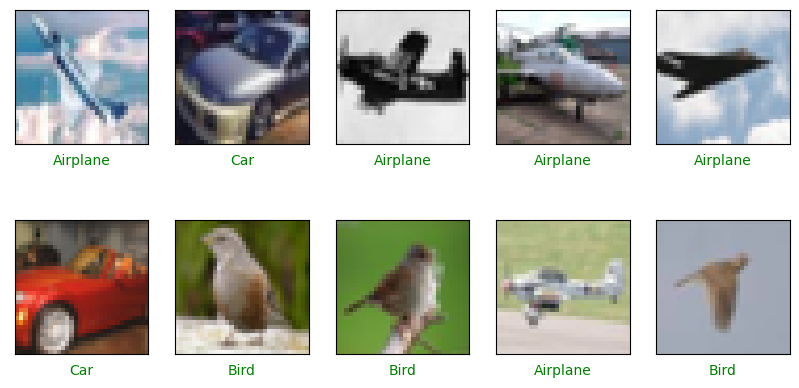

In [7]:
# Order of the class labels:
# [1.Airplane 2.Car 3.Bird 4.Cat 5.Deer 6.Dog 7.Frog 8.Horse 9.Ship 10.Truck]

class_names = ['Airplane', 'Car', 'Bird'] # Define class names

# Let's make sure everything is as expected
def show_random_examples(x, y, p): 
    indices = np.random.choice(range(x.shape[0]), 10, replace = False)
    
    x = x[indices] 
    y = y[indices] 
    p = p[indices] 
    
    plt.figure(figsize=(10, 5)) 
    for i in range(10):  
        plt.subplot(2, 5, 1+i)
        plt.imshow(x[i]) 
        plt.xticks([]) 
        plt.yticks([])
        
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color = col)
        
    plt.show()

show_random_examples(x_train, y_train, y_train)

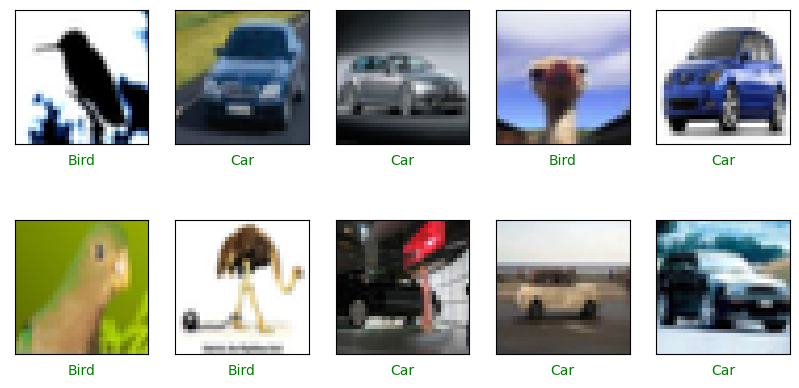

In [8]:
show_random_examples(x_test, y_test, y_test)

## Model Building

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Dropout(0.5))
        return model
    
    model= tf.keras.models.Sequential()
    model.add(Input(shape = (32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation = 'softmax'))
    
    
    model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam', metrics = ['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        1

2023-05-18 10:53:06.773935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train the Model

In [55]:
h = model.fit(
    x_train/225. , y_train,
    validation_data = (x_test/255. , y_test),
    epochs= 10 , batch_size = 128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy: .3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor = 'val_accuracy'
        )
    ]
)

Epoch 1/10
118/118 [==============================] - 21s 171ms/step - loss: 0.8940 - accuracy: 0.6821 - val_loss: 2.1933 - val_accuracy: 0.4760
Epoch 2/10
118/118 [==============================] - 20s 168ms/step - loss: 0.5486 - accuracy: 0.7785 - val_loss: 2.6144 - val_accuracy: 0.3803
Epoch 3/10
118/118 [==============================] - 20s 166ms/step - loss: 0.4730 - accuracy: 0.8095 - val_loss: 2.4539 - val_accuracy: 0.5353
Epoch 4/10
118/118 [==============================] - 20s 173ms/step - loss: 0.4392 - accuracy: 0.8266 - val_loss: 1.2163 - val_accuracy: 0.5357
Epoch 5/10
118/118 [==============================] - 20s 171ms/step - loss: 0.4110 - accuracy: 0.8397 - val_loss: 1.4277 - val_accuracy: 0.5863
Epoch 6/10
118/118 [==============================] - 20s 167ms/step - loss: 0.3787 - accuracy: 0.8539 - val_loss: 0.4472 - val_accuracy: 0.8267
Epoch 7/10
118/118 [==============================] - 19s 162ms/step - loss: 0.3444 - accuracy: 0.8684 - val_loss: 0.8741 - val_ac

## Final Prediction

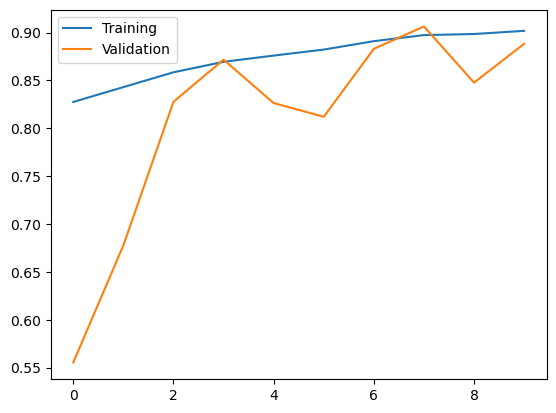

In [28]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label = 'Training')
plt.plot(range(len(accs)), val_accs, label = "Validation")
plt.legend()
plt.show()

In [29]:
model = tf.keras.models.load_model('models/model_ 0.906.h5')

In [30]:
prediction = model.predict(x_test/255.)

94/94 [==============================] - 2s 19ms/step


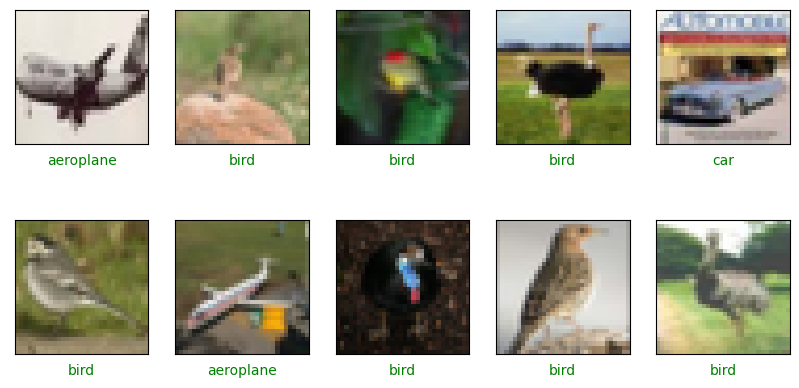

In [31]:
show_random_examples(x_test, y_test, prediction)